# Automatic Speech Recognition
## Exploring Biases in Transformer-Based End-to-End ASR Systems
* Arina Schippers
* Foteini Papadopoulou 

# Installations & Imports

In [1]:
!pip install jiwer librosa transformers git+https://github.com/openai/whisper.git pycountry-convert pycountry pycountry-convert kaleido scikit-posthocs --quiet

In [2]:
import csv
import time
import os
import matplotlib.pyplot as plt

import pandas as pd
import torch
import jiwer
import whisper
import librosa
from transformers import AutoModelForCTC, AutoProcessor, HubertForCTC, \
    Wav2Vec2ForCTC, Wav2Vec2Processor, WavLMForCTC, WavLMModel
import seaborn as sns

if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead.")
    device = torch.device("cpu")

2024-06-03 00:39:27.489875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 00:39:27.489993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 00:39:27.635181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is not available, using CPU instead.


In [3]:
class Config():
    PREPROCESS_DATASET = True
    DATASET_FILEPATH = '/kaggle/input/speech-accent-archive/'
    MODIFIED_DATASET_FILEPATH = '/kaggle/input/speech-accent-archive-modified/'
    TRANSCIRPTION_FILEPATH = '/kaggle/input/model-transcriptions'
CONFIG = Config()

# Read and explore the dataset

In [4]:
def explore_dataset():

    speakers_df = pd.read_csv(f'{CONFIG.DATASET_FILEPATH}speakers_all.csv')

    # print speaker csv info
    print(speakers_df.head())
    print(speakers_df.info())
    print(speakers_df.describe())
    print(speakers_df["Unnamed: 9"].value_counts())
    print(speakers_df["Unnamed: 10"].value_counts())
    print(speakers_df["Unnamed: 11"].value_counts())

    # drop unnecessary columns
    speakers_df = speakers_df.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1)

    print(speakers_df[speakers_df.isna().any(axis=1)])

    # drop rows with na birthplace and country
    speakers_df = speakers_df.dropna(subset=['birthplace', 'country'])

    speakers_df['age'].plot(kind='hist', edgecolor='black')

    speakers_df['country'].value_counts().head(5).plot.bar(figsize=(6, 8))

    # replace row with famale value
    speakers_df = speakers_df.replace('famale', 'female')
    
    speakers_df.loc[speakers_df['filename'] == 'nicaragua', 'file_missing?'] = True

    speakers_df = speakers_df[speakers_df['file_missing?'] == False]

    speakers_df.to_csv('speakers_modified.csv', index=False)
    return speakers_df

    age  age_onset              birthplace  filename native_language   sex  \
0  24.0       12.0         koussi, senegal   balanta         balanta  male   
1  18.0       10.0          buea, cameroon  cameroon        cameroon  male   
2  48.0        8.0  hong, adamawa, nigeria  fulfulde        fulfulde  male   
3  42.0       42.0   port-au-prince, haiti   haitian         haitian  male   
4  40.0       35.0   port-au-prince, haiti   haitian         haitian  male   

   speakerid   country  file_missing?  Unnamed: 9  Unnamed: 10 Unnamed: 11  
0        788   senegal           True         NaN          NaN         NaN  
1       1953  cameroon           True         NaN          NaN         NaN  
2       1037   nigeria           True         NaN          NaN         NaN  
3       1165     haiti           True         NaN          NaN         NaN  
4       1166     haiti           True         NaN          NaN         NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False
...,...,...,...,...,...,...,...,...,...
2167,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,766,nigeria,False
2168,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,851,nigeria,False
2169,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,2023,nigeria,False
2170,31.0,1.0,"bethel, alaska, usa",yupik1,yupik,female,571,usa,False


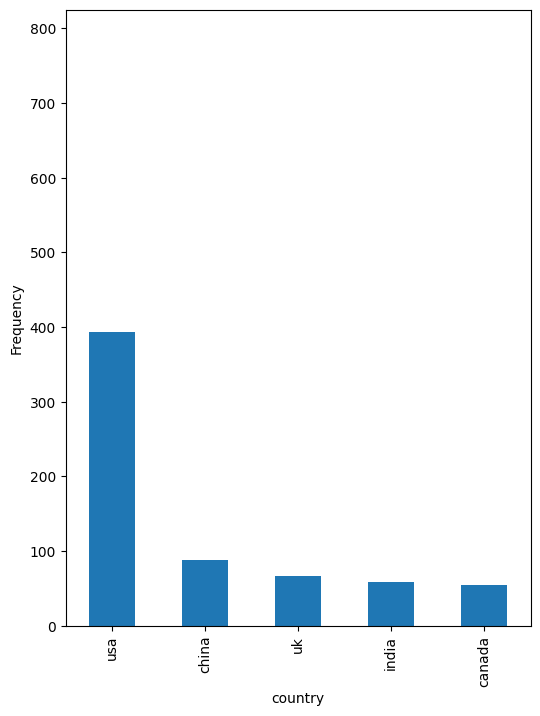

In [5]:
if CONFIG.PREPROCESS_DATASET is True:
    speakers_df = explore_dataset()
else:
    speakers_df = pd.read_csv(f'{CONFIG.MODIFIED_DATASET_FILEPATH}speakers_modified.csv')
speakers_df

### Creating a SpeechModel class to initialize for each transformer model

In [6]:
class SpeechModel:
    def __init__(self, name):
        self.name = name
        if name == 'whisper':
            self.model = whisper.load_model('large', device="cuda")
        elif name == 'wav2vec':
            self.processor = AutoProcessor.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")
            self.model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")
        elif name == 'hubert':
            self.processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
            self.model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft")
        elif name == 'MMS':
            self.processor = AutoProcessor.from_pretrained("facebook/mms-1b-all")
            self.model = Wav2Vec2ForCTC.from_pretrained("facebook/mms-1b-all")
        else:
            raise ValueError(f"Model {name} not supported")
        if torch.cuda.is_available():
            self.model = self.model.to(device)


    def transcribe(self, file_path):
        if self.name == 'whisper':
            return self._transcribe_whisper(file_path)
        elif self.name == 'wav2vec':
            return self._transcribe_wav2vec(file_path)
        elif self.name == 'hubert':
            return self._transcribe_hubert(file_path)
        elif self.name == 'MMS':
            return self._transcribe_MMS(file_path)
        else:
            raise ValueError(f"Model {self.name} not supported")

    def _transcribe_whisper(self, file_path):
        audio = whisper.load_audio(file_path)
        audio = whisper.pad_or_trim(audio)
        result = self.model.transcribe(audio)
        return result['text']

    def _transcribe_wav2vec(self, file_path):

        input_audio, sr = librosa.load(file_path, sr=16000)
        input_values = self.processor(input_audio, return_tensors="pt", sampling_rate=sr).input_values
        input_values = input_values.to(device) 
        with torch.no_grad():
            logits = self.model(input_values).logits
        logits = logits.cpu()
        pred_ids = torch.argmax(logits, axis=-1)
        transcription = self.processor.batch_decode(pred_ids)

        return transcription

    def _transcribe_hubert(self, file_path):
        return self._transcribe_wav2vec(file_path)

    def _transcribe_MMS(self, file_path):
        return self._transcribe_wav2vec(file_path)


    def calculate_error_rates(self, reference, hypothesis):
        transformation_words = jiwer.Compose([
            jiwer.ToLowerCase(),
            jiwer.RemovePunctuation(),
            jiwer.Strip(),
            jiwer.RemoveMultipleSpaces(),
            jiwer.ReduceToListOfListOfWords(),
        ])

        transformation_cars = jiwer.Compose([
            jiwer.RemovePunctuation(),
            jiwer.Strip(),
            jiwer.RemoveMultipleSpaces(),
            jiwer.ReduceToListOfListOfChars(),
        ])
        output_word = jiwer.process_words(reference, hypothesis, reference_transform=transformation_words, hypothesis_transform=transformation_words)
        cer = jiwer.cer(reference, hypothesis, reference_transform=transformation_cars, hypothesis_transform=transformation_cars)

        return output_word.wer, output_word.mer, output_word.wil, cer


In [7]:
def process_dataset(speakers_df, dataset_path, model):

    results = []

    reference = open(f'{CONFIG.DATASET_FILEPATH}reading-passage.txt').read()

    # get all the audio files in the dataset_path
    files = os.listdir(dataset_path)

    total_errors = 0
    total_words = 0
    num_words = len(reference.split())

    # iterate over all audio files in the dataset_path
    files = speakers_df.filename.to_list()

    start = time.time()
    for index,audio_path in enumerate(files):
        try:
            transcription = model.transcribe(os.path.join(dataset_path, f'{audio_path}.mp3'))
        
            wer, mer, wil, cer = model.calculate_error_rates(reference, transcription)

            total_errors += wer * num_words
            total_words += num_words
            results.append([audio_path, transcription, wer, mer, wil, cer])
        except Exception as e:
            print(e)

        if index % 100 == 0:
            print(f"{index} have been processed..")
            
    end = time.time()
    print(f'Took {end - start} seconds to process.')
    # Write results to a CSV
    with open(f'transcription_results_{model.name}.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Audio Path', 'Transcription', 'WER', 'MER', 'WIL', 'CER'])
        writer.writerows(results)

    # Calculate weighted average WER
    weighted_average_wer = total_errors / total_words if total_words > 0 else 0
    print(f"Overall weighted average WER: {weighted_average_wer:.2%}")
    return weighted_average_wer

In [8]:
#model = SpeechModel('whisper')

dataset_path = fr"{CONFIG.DATASET_FILEPATH}recordings/recordings"
#process_dataset(speakers_df, dataset_path, model)

In [9]:
model = SpeechModel('wav2vec')
#process_dataset(speakers_df, dataset_path, model)

preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a 

In [10]:
model = SpeechModel('hubert')
#process_dataset(speakers_df, dataset_path, model)

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-large-ls960-ft were not used when initializing HubertForCTC: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-

In [11]:
model = SpeechModel('MMS')
#process_dataset(speakers_df, dataset_path, model)

preprocessor_config.json:   0%|          | 0.00/254 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/mms-1b-all were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/mms-1b-all and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream

# Results tables with transcriptions

In [12]:
mms = pd.read_csv(f'{CONFIG.TRANSCIRPTION_FILEPATH}/transcription_results_MMS.csv')
hubert = pd.read_csv(f'{CONFIG.TRANSCIRPTION_FILEPATH}/transcription_results_hubert.csv')
wav2vec = pd.read_csv(f'{CONFIG.TRANSCIRPTION_FILEPATH}/transcription_results_wav2vec.csv')
whisper = pd.read_csv(f'{CONFIG.TRANSCIRPTION_FILEPATH}/transcription_results_whisper.csv')

In [13]:
# keep only WER and Audio Path columns
mms = mms[['Audio Path', 'WER']]
hubert = hubert[['Audio Path', 'WER']]
wav2vec = wav2vec[['Audio Path', 'WER']]
whisper = whisper[['Audio Path', 'WER']]

In [14]:
# merge tables transcriptions
merged_whisper_mms = pd.merge(whisper, mms, on='Audio Path', suffixes=('_whisper', '_mms'))
merged_wav_hubert = pd.merge(wav2vec, hubert, on='Audio Path', suffixes=('_wav', '_hubert'))

#merge all
merged = pd.merge(merged_whisper_mms, merged_wav_hubert, on='Audio Path')

merged = merged.rename(columns={"Audio Path": "filename"})

# remove the .mp3 suffix
merged['filename'] = merged['filename'].apply(lambda x: x.split('/')[-1].split('.')[0])

# merge with the demographics table
merged_df = pd.merge(speakers_df, merged, on='filename')

# make a nonnative column
merged_df['nonnative'] = merged_df['native_language'].apply(lambda x: True if x != 'english' else False)

# print the value counts of the nonnative column
print(merged_df['nonnative'].value_counts())

nonnative
True     1554
False     579
Name: count, dtype: int64


## Tables

In [15]:
# Calculate the average WER for nonnative and natives
grouped = merged_df.groupby('nonnative').agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
print(grouped)

   nonnative  WER_whisper   WER_mms  WER_hubert   WER_wav
0      False     0.021501  0.056244    0.033191  0.020425
1       True     0.150010  0.159374    0.132179  0.100218


In [16]:
# Calculate the average WER for native_language
grouped = merged_df.groupby('native_language').agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
print(grouped)

    native_language  WER_whisper   WER_mms  WER_hubert   WER_wav
0         afrikaans     0.002899  0.060870    0.049275  0.034783
1              agni     0.173913  0.304348    0.202899  0.173913
2              akan     0.028986  0.217391    0.144928  0.101449
3          albanian     0.035427  0.070853    0.085346  0.053140
4           amazigh     0.514493  0.282609    0.231884  0.217391
..              ...          ...       ...         ...       ...
194          yapese     0.028986  0.130435    0.101449  0.014493
195         yiddish     0.086957  0.130435    0.104348  0.081159
196          yoruba     0.257971  0.188406    0.156522  0.115942
197           yupik     0.000000  0.028986    0.014493  0.000000
198            zulu     0.014493  0.144928    0.072464  0.086957

[199 rows x 5 columns]


In [17]:
# Calculate the average WER for nonnative and natives and based on the gender of the speaker
grouped = merged_df.groupby(['nonnative', 'sex']).agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()

print(grouped)

   nonnative     sex  WER_whisper   WER_mms  WER_hubert   WER_wav
0      False  female     0.021846  0.053838    0.031347  0.019055
1      False    male     0.021200  0.058346    0.034801  0.021622
2       True  female     0.122305  0.153304    0.128041  0.096568
3       True    male     0.176735  0.165228    0.136170  0.103740


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


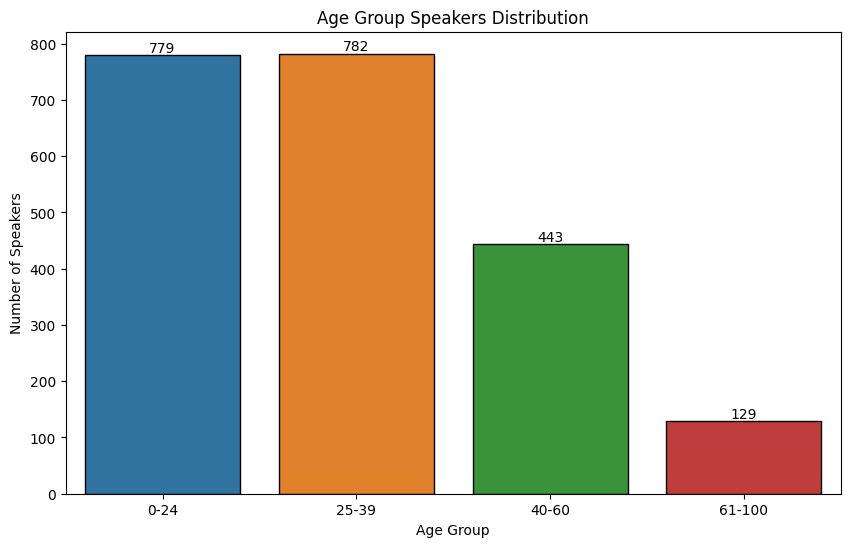

In [18]:
# make age groups balanced by exploring the age column
merged_df['age_group'] = pd.cut(merged_df['age'], 
                                bins=[0, 25, 40, 60, 100], 
                                labels=['0-24', '25-39', '40-60', '61-100'],
                                right=False)

# plot of the age distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='age_group', data=merged_df, edgecolor = "black")
ax.bar_label(ax.containers[0])
plt.title('Age Group Speakers Distribution')
plt.ylabel('Number of Speakers')
plt.xlabel('Age Group')
plt.savefig('age.png')
plt.show()

In [19]:
# Calculate the average WER for nonnative and based on the age group of the speaker
grouped = merged_df.groupby(['nonnative', 'age_group']).agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
print(grouped)

   nonnative age_group  WER_whisper   WER_mms  WER_hubert   WER_wav
0      False      0-24     0.009576  0.057195    0.033126  0.019345
1      False     25-39     0.021462  0.049735    0.029381  0.016631
2      False     40-60     0.017598  0.052148    0.030280  0.018504
3      False    61-100     0.073430  0.080193    0.050483  0.039614
4       True      0-24     0.113540  0.152944    0.118736  0.090351
5       True     25-39     0.145000  0.160945    0.135298  0.102514
6       True     40-60     0.205132  0.162091    0.141687  0.107535
7       True    61-100     0.222432  0.184415    0.167612  0.124554


/tmp/ipykernel_18/3226175880.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = merged_df.groupby(['nonnative', 'age_group']).agg(


In [20]:
# Calculate the average WER for country of the speaker
grouped = merged_df.groupby(['country']).agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
print(grouped)

         country  WER_whisper   WER_mms  WER_hubert   WER_wav
0    afghanistan     0.225916  0.148338    0.183291  0.139812
1        albania     0.066667  0.072464    0.078261  0.043478
2        algeria     0.264493  0.108696    0.083333  0.054348
3        andorra     0.000000  0.173913    0.101449  0.072464
4         angola     0.182609  0.165217    0.139130  0.092754
..           ...          ...       ...         ...       ...
171     virginia     0.014493  0.057971    0.057971  0.014493
172        yemen     0.028986  0.217391    0.202899  0.159420
173   yugoslavia     0.188406  0.043478    0.115942  0.057971
174       zambia     0.014493  0.028986    0.028986  0.014493
175     zimbabwe     0.004831  0.077295    0.053140  0.028986

[176 rows x 5 columns]


In [21]:
import pycountry
def get_iso_alpha(country):
    try:
        return pycountry.countries.get(name=country).alpha_3
    except:
        # match specific countries
        if country == 'usa':
            return 'USA'
        elif country == 'uk':
            return 'GBR'
        elif country == 'bolivia':
            return 'BOL'
        elif country == 'bosnia':
            return 'BIH'
        elif country == 'curacao':
            return 'CUW'
        elif country == 'czech republic':
            return 'CZE'
        elif country == 'democratic republic of congo':
            return 'COD'
        elif country == 'federated states of micronesia':
            return 'FSM'
        elif country == 'iran':
            return 'IRN'
        elif country == 'israel (occupied territory)':
            return 'ISR'
        elif country == 'ivory coast':
            return 'CIV'
        elif country == 'laos':
            return 'LAO'
        elif country == 'kosovo':
            return 'XKX'
        elif country == 'macedonia':
            return 'MKD'
        elif country == 'moldova':
            return 'MDA'
        elif country == 'republic of georgia':
            return 'GEO'
        elif country == 'romanian':
            return 'ROU'
        elif country == 'russia':
            return 'RUS'
        elif country == 'sicily':
            return 'ITA'
        elif country == 'south korea':
            return 'KOR'
        elif country == 'slovak republic':
            return 'SVK'
        elif country == 'syria':
            return 'SYR'
        elif country == 'taiwan':
            return 'TWN'
        elif country == 'tanzania':
            return 'TZA'
        elif country == 'the bahamas':
            return 'BHS'
        elif country == 'tibet':
            return 'CHN'
        elif country == 'trinidad':
            return 'TTO'
        elif country == 'turkey':
            return 'TUR'
        elif country == 'us virgin islands':
            return 'VIR'
        elif country == 'venezuela':
            return 'VEN'
        elif country == 'vietnam':
            return 'VNM'
        elif country == 'virginia':
            return 'USA'
        elif country == 'yugoslavia':
            return 'SRB'

In [22]:
import pycountry_convert as pc

def get_continent(iso_alpha):
    try:
        alpha2 = pc.country_alpha3_to_country_alpha2(iso_alpha)
        country_continent_code = pc.country_alpha2_to_continent_code(alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None

In [23]:
merged_df['iso_alpha'] = merged_df['country'].apply(get_iso_alpha)
merged_df['continent'] = merged_df['iso_alpha'].apply(get_continent)

merged_df.loc[merged_df['filename'] == 'fataluku1', 'continent'] = 'Asia'
merged_df.loc[merged_df['country'] == 'kosovo', 'continent'] = 'Europe'

In [24]:
# Calculate the average WER for nonnative and based on the continent of the speaker
grouped = merged_df.groupby(['nonnative', 'continent']).agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
grouped = grouped.round(4)
print(grouped)

    nonnative      continent  WER_whisper  WER_mms  WER_hubert  WER_wav
0       False         Africa       0.0952   0.1077      0.0621   0.0621
1       False           Asia       0.0176   0.0787      0.0424   0.0290
2       False         Europe       0.0719   0.0787      0.0573   0.0404
3       False  North America       0.0121   0.0498      0.0274   0.0153
4       False        Oceania       0.0090   0.0604      0.0331   0.0197
5       False  South America       0.0338   0.1014      0.1063   0.0870
6        True         Africa       0.1927   0.1792      0.1580   0.1255
7        True           Asia       0.1996   0.1801      0.1590   0.1206
8        True         Europe       0.0818   0.1246      0.0898   0.0649
9        True  North America       0.1636   0.1730      0.1481   0.1162
10       True        Oceania       0.0245   0.0716      0.0417   0.0299
11       True  South America       0.1083   0.1607      0.1219   0.0911


In [25]:
# Calculate the average WER based on the continent of the speaker
average_wer = grouped.groupby('continent').agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
print(average_wer)

       continent  WER_whisper  WER_mms  WER_hubert  WER_wav
0         Africa      0.14395  0.14345     0.11005  0.09380
1           Asia      0.10860  0.12940     0.10070  0.07480
2         Europe      0.07685  0.10165     0.07355  0.05265
3  North America      0.08785  0.11140     0.08775  0.06575
4        Oceania      0.01675  0.06600     0.03740  0.02480
5  South America      0.07105  0.13105     0.11410  0.08905


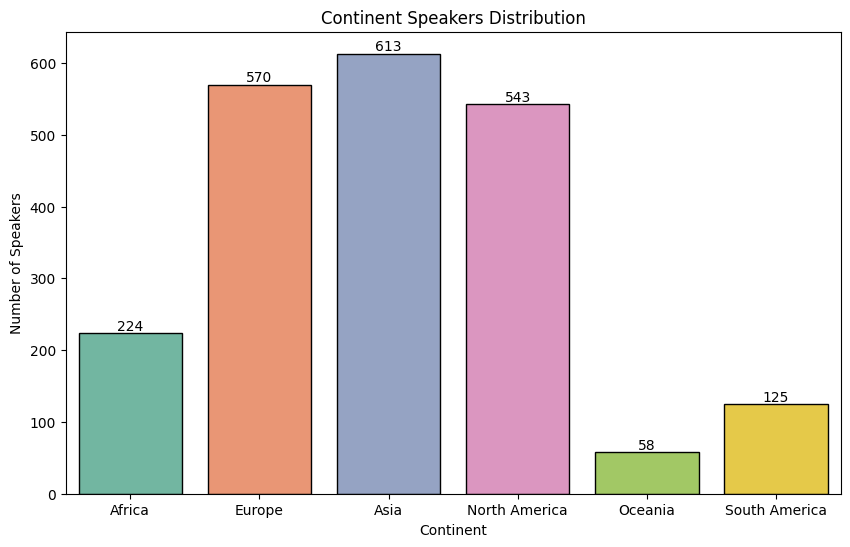

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='continent', data=merged_df, palette = "Set2", edgecolor = "black")
ax.bar_label(ax.containers[0])
plt.title('Continent Speakers Distribution')
plt.ylabel('Number of Speakers')
plt.xlabel('Continent')
plt.savefig('continent.png')
plt.show()

In [27]:
# Calculate the average WER for native-language
grouped = merged_df.groupby(['native_language']).agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
print(grouped)

    native_language  WER_whisper   WER_mms  WER_hubert   WER_wav
0         afrikaans     0.002899  0.060870    0.049275  0.034783
1              agni     0.173913  0.304348    0.202899  0.173913
2              akan     0.028986  0.217391    0.144928  0.101449
3          albanian     0.035427  0.070853    0.085346  0.053140
4           amazigh     0.514493  0.282609    0.231884  0.217391
..              ...          ...       ...         ...       ...
194          yapese     0.028986  0.130435    0.101449  0.014493
195         yiddish     0.086957  0.130435    0.104348  0.081159
196          yoruba     0.257971  0.188406    0.156522  0.115942
197           yupik     0.000000  0.028986    0.014493  0.000000
198            zulu     0.014493  0.144928    0.072464  0.086957

[199 rows x 5 columns]


# Map plots

In [28]:
import plotly.express as px
from urllib.request import urlopen
import json

# load the geojson file for the choropleth map
with urlopen('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json') as response:
    countries = json.load(response)

In [29]:
grouped_c = merged_df.groupby(['country','iso_alpha']).agg(
    {'WER_whisper': 'mean', 'WER_mms': 'mean', 'WER_hubert': 'mean', 'WER_wav': "mean"}).reset_index()
grouped_c = grouped_c.round(4)
print(grouped_c.sort_values(by='WER_mms', ascending=False).head(10))
print(grouped_c.sort_values(by='WER_hubert', ascending=False).head(10))
print(grouped_c.sort_values(by='WER_whisper', ascending=False).head(10))
print(grouped_c.sort_values(by='WER_wav', ascending=False).head(10))

               country iso_alpha  WER_whisper  WER_mms  WER_hubert  WER_wav
33          costa rica       CRI       0.1957   0.4348      0.3406   0.3406
110          nicaragua       NIC       0.3120   0.3265      0.3240   0.2702
29                chad       TCD       0.9710   0.3188      0.4783   0.3913
45   equatorial guinea       GNQ       0.0435   0.3043      0.3043   0.2464
156               togo       TGO       0.2899   0.3043      0.2319   0.1957
170            vietnam       VNM       0.2181   0.2938      0.2668   0.2095
93          madagascar       MDG       0.5797   0.2899      0.3043   0.3188
152           thailand       THA       0.2406   0.2889      0.2319   0.1932
105            myanmar       MMR       0.1775   0.2862      0.2391   0.2283
37              cyprus       CYP       0.6449   0.2826      0.2971   0.2174
                  country iso_alpha  WER_whisper  WER_mms  WER_hubert  WER_wav
29                   chad       TCD       0.9710   0.3188      0.4783   0.3913
33    

In [30]:
def choropleth_map(df, color_column):
    df
    fig = px.choropleth(df,
                        locations="iso_alpha",
                        color=color_column,
                        hover_name="country",
                        title=f"Average {color_column} by Country",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        range_color=(0, 1))
    fig.show()
    fig.write_html(f"/kaggle/working/{color_column}.html")
    fig.write_image(f"/kaggle/working/{color_column}.png")

choropleth_map(grouped_c, color_column='WER_whisper')

In [31]:
choropleth_map(grouped_c, color_column='WER_hubert')

In [32]:
choropleth_map(grouped_c, color_column='WER_mms')

In [33]:
choropleth_map(grouped_c, color_column='WER_wav')

## Graphs

In [34]:
models = ["WER_whisper", "WER_mms","WER_wav","WER_hubert"]
models_names = ["Whisper", "MMS","Wav2vec 2.0","HuBERT"]

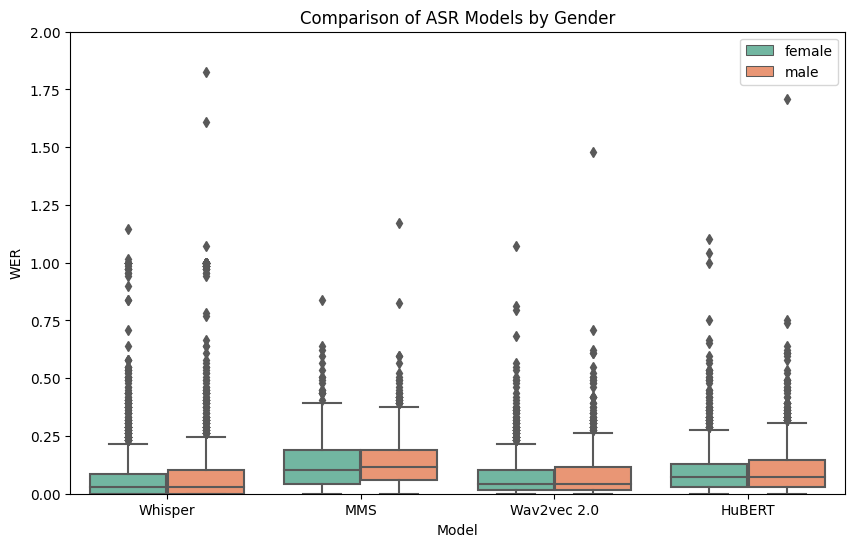

In [35]:
# Boxplot gender
long_df = merged_df.melt(id_vars=['sex'], value_vars=models, var_name='Model', value_name='WER')
plt.figure(figsize=(10, 6)) 
ax = sns.boxplot(x='Model', y='WER', hue='sex', data=long_df, palette='Set2')
plt.title('Comparison of ASR Models by Gender')
ax.set_xticklabels(models_names)
ax.set_ylim(0, 2)
legend = ax.legend(loc='upper right')
legend.get_title().set_fontsize('12') 
legend.set_bbox_to_anchor((1, 1))
plt.savefig(f"gender_plot.png")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



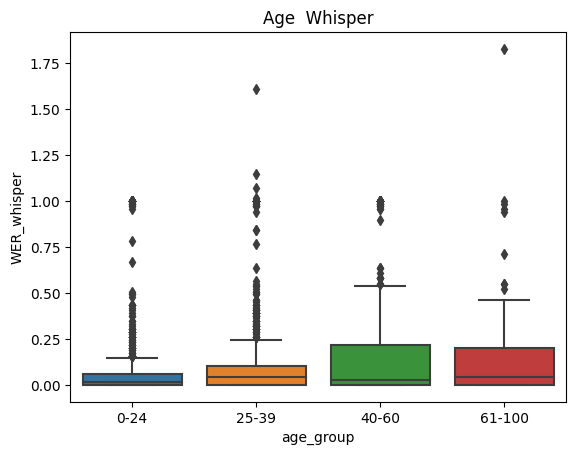

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



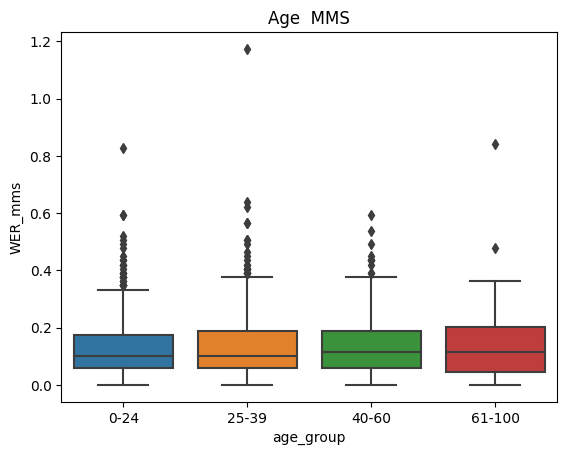

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



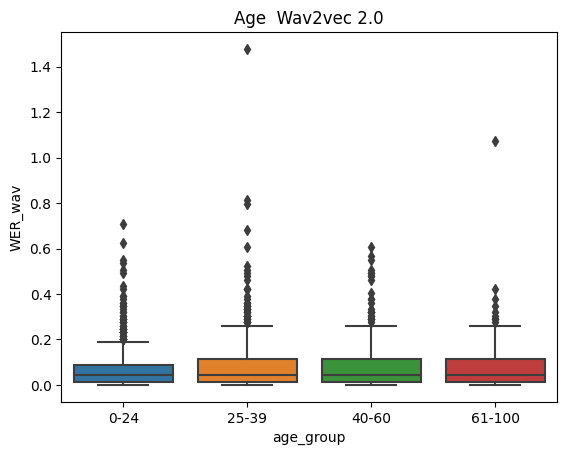

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



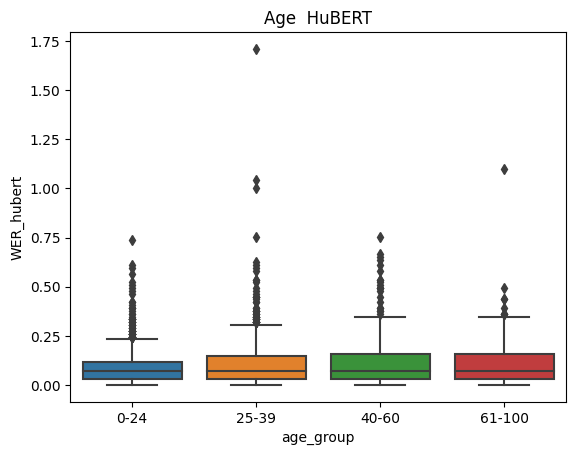

In [36]:
# Boxplot with age groups
for model,name in zip(models, models_names):
    sns.boxplot(x = merged_df["age_group"],  y = merged_df[f"{model}"]).set(title = f"Age  {name}")
    plt.show()

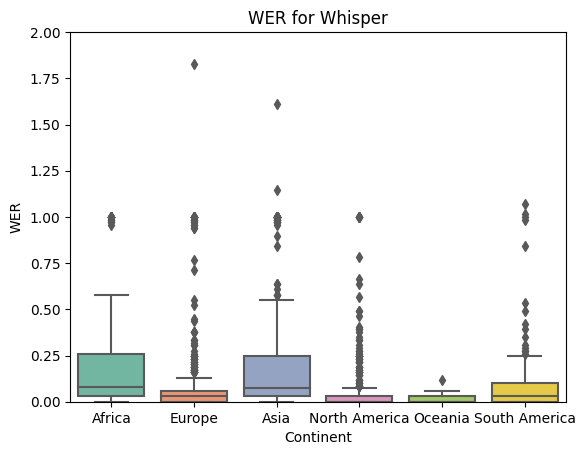

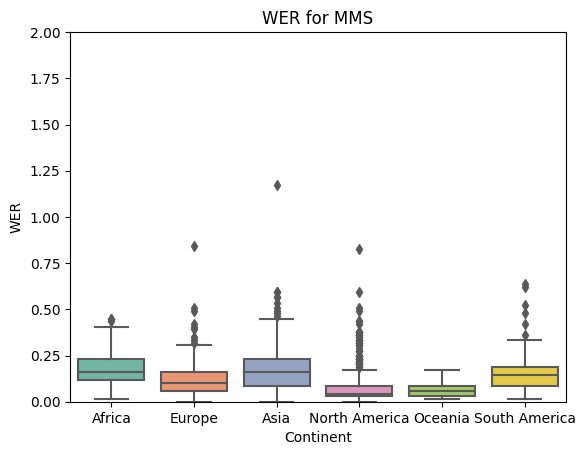

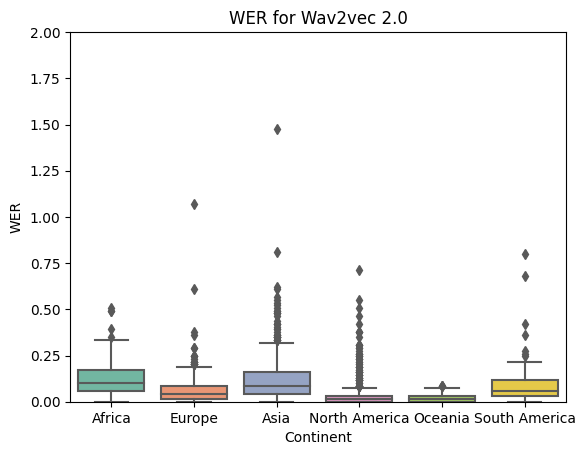

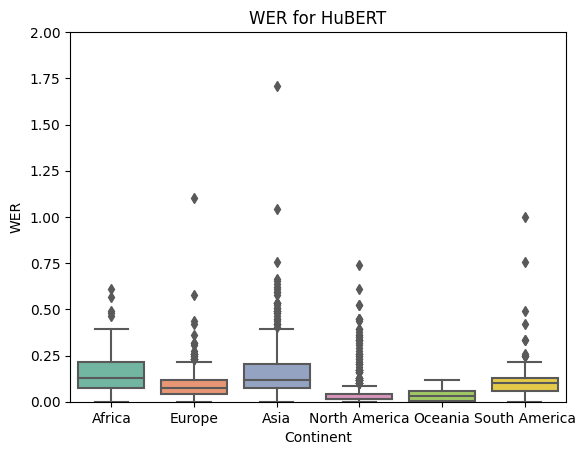

In [37]:
# Boxplot continents
for model, name in zip(models, models_names):
    ax = sns.boxplot(x = merged_df["continent"],  y = merged_df[f"{model}"],palette='Set2')
    plt.ylabel('WER')
    plt.xlabel('Continent')
    plt.title(f'WER for {name}') 
    ax.set_ylim(0, 2)
    plt.savefig(f"{name}_plot.png")
    plt.show()

## Statistical difference
### Kruskal-Wallis Test with Post-hoc Dunn's Test¶

In [38]:
import scipy.stats as stats
import scikit_posthocs as sp

In [39]:
def kruskal_test(subset, model_name):
    # Kruskal-Wallis Test
    groups = merged_df['group'].unique()
    group_data = [subset[subset['group'] == group][model_name] for group in groups]
    stat, p = stats.kruskal(*group_data)
    print(f'Kruskal-Wallis Test Statistic: {stat}, p-value: {p}')
    
    # Post-hoc Dunn's Test if Kruskal-Wallis test is significant
    if p < 0.05:
        posthoc_results = sp.posthoc_dunn(subset, val_col=model_name, group_col='group', p_adjust='bonferroni')
        print("Dunn's post-hoc test p-values with Bonferroni correction:\n")
#         display(posthoc_results) Uncomment to check the table
        
        # sort the results to get meaningful results
        results_long = posthoc_results.unstack().reset_index()
        results_long.columns = ['Group1', 'Group2', 'P-Value']
        results = results_long[results_long['P-Value'] < 0.05]
        
        # sort based on p-value
        significant_sorted = results.sort_values(by='P-Value')
        significant_sorted = significant_sorted[significant_sorted['Group1'] < significant_sorted['Group2']]
        
        # remove the duplicate groups
        results = results.copy()
        results['sorted'] = results.apply(lambda x: sorted([x['Group1'], x['Group2']]), axis=1)
        results['Group1_sorted'] = results['sorted'].apply(lambda x: x[0])
        results['Group2_sorted'] = results['sorted'].apply(lambda x: x[1])
        results = results.drop_duplicates(subset=['Group1_sorted', 'Group2_sorted'])
        results = results.drop(columns=['sorted', 'Group1_sorted', 'Group2_sorted'])
        results = results.sort_values(by='P-Value')
        print(results)

    else:
        print("No significant differences found.")
    
subset = merged_df

In [40]:
subset['group'] = subset['continent'].astype(str) #  + "_" + subset['nonnative']
print("#### Continents for Hubert")
kruskal_test(subset, model_name='WER_hubert')
print("#### Continents for MMS")
kruskal_test(subset, model_name='WER_mms')
print("#### Continents for Whisper")
kruskal_test(subset, model_name='WER_whisper')
print("#### Continents for Wav2vec")
kruskal_test(subset, model_name='WER_wav')

#### Continents for Hubert
Kruskal-Wallis Test Statistic: 591.5110073889527, p-value: 1.3803225208819066e-125
Dunn's post-hoc test p-values with Bonferroni correction:

           Group1         Group2       P-Value
9            Asia  North America  2.409322e-99
3          Africa  North America  1.340277e-63
15         Europe  North America  3.999062e-30
23  North America  South America  1.188251e-24
8            Asia         Europe  1.715756e-20
4          Africa        Oceania  2.552398e-20
10           Asia        Oceania  2.650738e-20
2          Africa         Europe  2.103996e-15
29        Oceania  South America  7.980167e-11
16         Europe        Oceania  7.567385e-07
17         Europe  South America  7.264587e-03
#### Continents for MMS
Kruskal-Wallis Test Statistic: 551.1256172182997, p-value: 7.305490759094044e-117
Dunn's post-hoc test p-values with Bonferroni correction:

           Group1         Group2       P-Value
9            Asia  North America  9.815789e-93
3       

In [41]:
subset['group'] = subset['sex'].astype(str) #  + "_" + subset['nonnative'] 
print("#### Gender for Hubert")
kruskal_test(subset, model_name='WER_hubert')
print("#### Gender for MMS")
kruskal_test(subset, model_name='WER_mms')
print("#### Gender for Whisper")
kruskal_test(subset, model_name='WER_whisper')
print("#### Gender for Wav2vec")
kruskal_test(subset, model_name='WER_wav')

#### Gender for Hubert
Kruskal-Wallis Test Statistic: 1.5359057149559154, p-value: 0.21522826160075836
No significant differences found.
#### Gender for MMS
Kruskal-Wallis Test Statistic: 2.7765105056323063, p-value: 0.09565637591123363
No significant differences found.
#### Gender for Whisper
Kruskal-Wallis Test Statistic: 8.077902807613288, p-value: 0.004480827182856178
Dunn's post-hoc test p-values with Bonferroni correction:

   Group1 Group2   P-Value
1  female   male  0.004481
#### Gender for Wav2vec
Kruskal-Wallis Test Statistic: 2.4677346152169126, p-value: 0.11620530146743788
No significant differences found.


In [42]:
subset['group'] = subset['native_language'].astype(str)
print("#### Native Language for Hubert")
kruskal_test(subset, model_name='WER_hubert')
print("#### Native Language for MMS")
kruskal_test(subset, model_name='WER_mms')
print("#### Native Language for Whisper")
kruskal_test(subset, model_name='WER_whisper')
print("#### Native Language for Wav2vec")
kruskal_test(subset, model_name='WER_wav')

#### Native Language for Hubert
Kruskal-Wallis Test Statistic: 987.7149196155352, p-value: 4.119205398126486e-105
Dunn's post-hoc test p-values with Bonferroni correction:

          Group1      Group2       P-Value
7923     english     spanish  3.660030e-45
7871     english    mandarin  1.938660e-34
1233      arabic     english  1.244347e-27
7854     english      korean  2.545258e-25
7948     english  vietnamese  4.790866e-16
7941     english     turkish  3.018646e-14
7811     english      french  1.702398e-10
7937     english        thai  2.882745e-10
7898     english  portuguese  2.046869e-09
1034     amharic     english  3.384159e-09
4616   cantonese     english  4.597057e-09
7878     english     miskito  1.305344e-08
7887     english      nepali  5.883428e-08
7905     english     russian  9.580530e-07
7274       dutch    mandarin  1.225257e-06
7839     english     italian  2.054263e-06
7897     english      polish  1.192176e-05
7351       dutch  vietnamese  3.320055e-05
7257      

In [43]:
subset['group'] = subset['age_group'].astype(str)
print("#### Age Group for Hubert")
kruskal_test(subset, model_name='WER_hubert')
print("#### Age Group for MMS")
kruskal_test(subset, model_name='WER_mms')
print("#### Age Group for Whisper")
kruskal_test(subset, model_name='WER_whisper')
print("#### Age Group for Wav2vec")
kruskal_test(subset, model_name='WER_wav')

#### Age Group for Hubert
Kruskal-Wallis Test Statistic: 7.538841252341628, p-value: 0.05656880813176609
No significant differences found.
#### Age Group for MMS
Kruskal-Wallis Test Statistic: 3.089891485162328, p-value: 0.377972259757053
No significant differences found.
#### Age Group for Whisper
Kruskal-Wallis Test Statistic: 29.791848143350204, p-value: 1.5264302349217384e-06
Dunn's post-hoc test p-values with Bonferroni correction:

  Group1  Group2   P-Value
2   0-24   40-60  0.000031
1   0-24   25-39  0.000589
3   0-24  61-100  0.003599
#### Age Group for Wav2vec
Kruskal-Wallis Test Statistic: 5.83586164626093, p-value: 0.11987478885871451
No significant differences found.


In [44]:
subset['group'] = subset['nonnative'].astype(str)
print("#### Native Language for Hubert")
kruskal_test(subset, model_name='WER_hubert')
print("#### Native Language for MMS")
kruskal_test(subset, model_name='WER_mms')
print("#### Native Language for Whisper")
kruskal_test(subset, model_name='WER_whisper')
print("#### Native Language for Wav2vec")
kruskal_test(subset, model_name='WER_wav')

#### Native Language for Hubert
Kruskal-Wallis Test Statistic: 627.5771533856475, p-value: 1.681782676532655e-138
Dunn's post-hoc test p-values with Bonferroni correction:

  Group1 Group2        P-Value
1  False   True  1.681783e-138
#### Native Language for MMS
Kruskal-Wallis Test Statistic: 628.6883922307999, p-value: 9.640165292684397e-139
Dunn's post-hoc test p-values with Bonferroni correction:

  Group1 Group2        P-Value
1  False   True  9.640165e-139
#### Native Language for Whisper
Kruskal-Wallis Test Statistic: 409.9657252952457, p-value: 3.728955444902044e-91
Dunn's post-hoc test p-values with Bonferroni correction:

  Group1 Group2       P-Value
1  False   True  3.728955e-91
#### Native Language for Wav2vec
Kruskal-Wallis Test Statistic: 568.5463046335119, p-value: 1.1628807953712668e-125
Dunn's post-hoc test p-values with Bonferroni correction:

  Group1 Group2        P-Value
1  False   True  1.162881e-125


In [45]:
subset['group'] = subset['country'].astype(str)
print("#### country for Hubert")
kruskal_test(subset, model_name='WER_hubert')
print("#### country for MMS")
kruskal_test(subset, model_name='WER_mms')
print("#### country for Whisper")
kruskal_test(subset, model_name='WER_whisper')
print("#### country for Wav2vec")
kruskal_test(subset, model_name='WER_wav')

#### country for Hubert
Kruskal-Wallis Test Statistic: 1053.012067256691, p-value: 2.9311610055167154e-125
Dunn's post-hoc test p-values with Bonferroni correction:

             Group1   Group2       P-Value
5623          china      usa  1.335551e-51
25159   south korea      usa  3.131460e-28
4959         canada    china  2.258690e-21
8615       ethiopia      usa  4.733228e-19
29562           usa  vietnam  2.976817e-18
...             ...      ...           ...
24986  south africa  vietnam  3.929298e-02
1475      australia     iran  4.534396e-02
1484      australia    japan  4.574128e-02
5527          china   israel  4.793488e-02
19486     nicaragua  romania  4.812893e-02

[141 rows x 3 columns]
#### country for MMS
Kruskal-Wallis Test Statistic: 1086.2687850434422, p-value: 2.5759338567503323e-131
Dunn's post-hoc test p-values with Bonferroni correction:

            Group1       Group2       P-Value
5623         china          usa  1.335751e-55
25159  south korea          usa  6.401